# Workflow CAVE + HpBandster

We will present you a example workflow of how to efficiently optimize a algorithm using our frameworks 
<a href="https://github.com/automl/CAVE" target="_blank">CAVE</a> and <a href="https://github.com/automl/HpBandSter" target="_blank">HpBandSter</a>

## Short introduction to the used frameworks
### CAVE

Hier sollte eine kurze Beschreibung von Cave stehen.

### HpBandSter

Modern deep learning methods are very sensitive to many hyperparameters, and, due to the long training times of state-of-the-art models, vanilla Bayesian hyperparameter optimization is typically computationally infeasible. On the other hand, bandit-based configuration evaluation approaches based on random search lack guidance and do not converge to the best configurations as quickly. With HpBanster, we propose to combine the benefits of both Bayesian optimization and bandit-based methods, in order to achieve the best of both worlds: strong anytime performance and fast convergence to optimal configurations. We propose a new practical state-of-the-art hyperparameter optimization method, which consistently outperforms both Bayesian optimization and Hyperband on a wide range of problem types, including high-dimensional toy functions, support vector machines, feed-forward neural networks, Bayesian neural networks, deep reinforcement learning, and convolutional neural networks. Our method is robust and versatile, while at the same time being conceptually simple and easy to implement.

For more insights, please consider the paper: <a href="https://arxiv.org/abs/1807.01774" target="_blank">BOHB: Robust and Efficient Hyperparameter Optimization at Scale</a>

## The Workflow


In the next section, we guide you through the following steps:
#### 1) Given a algorithm to optimize and a *configuration space*, we will run BOHB on this problem. 
This step contains: 
1. Setting up a worker, which runs the given algorithmn with all the sampled configurations. Here it's a simple scipy implementation of a svm, training to classify the MNISTdataset.
2. Defining a configurations space for the classifier using our <a href="https://github.com/automl/ConfigSpace" target="_blank">ConfigSpace module</a>.
3. Setting up a nameserver, which organizes the possible multiple workers and starting the optimizer, here BOHB.


This will return us the optimization run results. For example the best hyperparameter configuration, which is often referred to as *incumbent*. 
Also a lot of information like which configurations has been used, as well as their performances.
#### 2) We will pass the BOHB results into the CAVE-tool.
It will give insights into the 
1. Parameter importance, 
2. performance analysis,
3. feature analysis and 
4. configuration behaviour.

### 1.1) Setting up a worker class
+ inherit from the hpbandster.core.worker class
+ load the mnist data in the init-method
+ overwrite the compute methode: the training of the model happens here
+ make sure that the returned dictionary contains the fields **loss** and **info**

In [1]:
from sklearn import datasets, neural_network, metrics
from hpbandster.core.worker import Worker

class MyWorker(Worker):
    def __init__(self, *args, **kwargs):
        super(MyWorker, self).__init__(*args, **kwargs)
        # We are loading the MNIST dataset and split it into a
        # training and a test set.
        digits = datasets.load_digits()
        n_samples = len(digits.images)
        data = digits.images.reshape((n_samples, -1))
        
        self.train_x = data[:n_samples // 2]
        self.train_y = digits.target[:n_samples // 2]
        self.test_x = data[n_samples // 2:]
        self.test_y = digits.target[n_samples // 2:]

    def compute(self, config, budget, *args, **kwargs):
        """
        Simple example for a compute function. It'll be repeatedly called by the optimizer. 
        
        Args:
            config: dictionary containing the sampled configurations by the optimizer
            budget: (float) amount of time/epochs/etc. the model can use to train

        Returns:
            dictionary with mandatory fields:
                'loss' (scalar)
                'info' (dict)
        """
        beta_1 = 0  if 'beta_1' not in config else config['beta_1']
        beta_2 = 0  if 'beta_2' not in config else config['beta_2']
        
        clf = neural_network.MLPClassifier(max_iter=int(budget),
                                           learning_rate='constant',
                                           learning_rate_init=config['learning_rate_init'],
                                           activation=config['activation'],
                                           solver=config['solver'],
                                           beta_1=beta_1, 
                                           beta_2=beta_2
                                          )
        clf.fit(self.train_x, self.train_y)
        
        predicted = clf.predict(self.test_x)
        loss_train = metrics.log_loss(self.train_y, clf.predict_proba(self.train_x))
        loss_test = metrics.log_loss(self.test_y, clf.predict_proba(self.test_x))

        accuracy_train = clf.score(self.train_x, self.train_y)
        accuracy_test = clf.score(self.test_x, self.test_y)
        
        # print(clf.n_iter_)
                
        # print("Classification report for classifier %s:\n%s\n"
        #       % (classifier, metrics.classification_report(self.test_y, predicted)))
        # print("Confusion matrix:\n%s" % metrics.confusion_matrix(self.test_y, predicted))
        
        return ({
            'loss': loss_train,  # this is the a mandatory field to run hyperband
            'info': {'loss_train': loss_train,
                     'loss_test': loss_test,
                     'accuracy_train': accuracy_train,
                     'accuracy_test': accuracy_test,
                     
                    }  # can be used for any user-defined information - also mandatory
        })

### 1.2) ConfigSpace:
Now we define the configuration space with the hyperparameters we'd like to optimize.

In [3]:
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
import ConfigSpace.read_and_write.json as json_writer

def sample_configspace():
    config_space = CS.ConfigurationSpace()
    config_space.add_hyperparameter(CSH.CategoricalHyperparameter('activation', ['tanh', 'relu']))
    config_space.add_hyperparameter(CS.UniformFloatHyperparameter('learning_rate_init', lower=1e-6, upper=1e-2, log=True))
    
    solver = CSH.CategoricalHyperparameter('solver', ['sgd', 'adam'])
    config_space.add_hyperparameter(solver)
    
    beta_1 = CS.UniformFloatHyperparameter('beta_1', lower=0, upper=1)
    config_space.add_hyperparameter(beta_1)
    
    condition = CS.EqualsCondition(beta_1, solver, 'adam')
    config_space.add_condition(condition)
    
    beta_2 = CS.UniformFloatHyperparameter('beta_2', lower=0, upper=1)
    config_space.add_hyperparameter(beta_2)
    
    condition = CS.EqualsCondition(beta_2, solver, 'adam')
    config_space.add_condition(condition)
    
    return config_space

### 1.3) Setting up the HpBandSter Nameserver and starting the optimization run
HpBandster supports parallel computation. To organize the workers, which can run on either a local machine or a cluster.  
We import also the ConfigSpace-to-json-writer, to save the configuration space to file, which we will use later in CAVE.

**NOTE:** Unfortunately, this step is *not done automatically* but is mandatory for the analysis with CAVE.  
We recommend to save the configuration space every time you use BOHB.

**Step 1:**  
Every run needs a nameserver. It could be a 'static' server with a permanent address, but here it will be started for the local machine with a random port.  
The nameserver manages the concurrent running workers across all possible threads or clusternodes.

**Step 2:**  
The worker implements the connection to the model to be evaluated. Its 'compute'-method will be called later by the BOHB-optimizer repeatedly with the sampled configurations and return the computed loss (and additional infos).

**Step 3:**  
In the last of the 3 Steps, we create an optimizer object.It samples configurations from the ConfigurationSpace, using succesive halving. The number of sampled configurations is determined by the parameters eta, min_budget and max_budget.  
After evaluating each configuration, starting with the minimum budget on the same subset size, only a fraction of 1 / eta of them *advances* to the next round. At the same time the current budget will be doubled. This process runs until the maximum budget is reached.  
And it will be repeated for *n_iterations* runs.

**NOTE:** BOHB does not build a new model at the beginning of every SuccessiveHalving run. Instead it collects all evaluations on all budgets and uses the largest budget with enough evaluations as a base for future evaluations.  

**Step 4:**  
Bohb will return a result object, which can be used to get informations about the incumbent (=best configuration) or the incumbent trajectory.  
The results will be stored, if not specified, to the current working directory.

In [10]:
import logging
logging.basicConfig(level=logging.INFO)

import ConfigSpace.read_and_write.json as json_writer
import hpbandster.core.nameserver as hpns

from hpbandster.optimizers import BOHB as BOHB

# Create a configuration space
config_space = sample_configspace()

# Write the ConfigSpace for later use to file
with open('example1_configspace.json', 'w') as fh:
    fh.write(json_writer.write(config_space))

# Every run has to have a unique (at runtime) id.
run_id = '0'

# Step 1: Set up the nameserver
NS = hpns.NameServer(run_id=run_id, host='localhost', port=0)
ns_host, ns_port = NS.start()

# Step 2: Connect the worker with the nameserver
w = MyWorker(nameserver=ns_host,
             nameserver_port=ns_port,
             run_id=run_id,  # unique Hyperband run id (same as nameserver's)
            )
w.run(background=True)

# Step 3: Create the optimizer object and run it
bohb = BOHB(  configspace = config_space,
              run_id = run_id,  # same as nameserver's
              eta=2, min_budget=5, max_budget=100,  # Hyperband parameters
              nameserver=ns_host,
              nameserver_port = ns_port,
              ping_interval=3600,  # how often master pings for workers (in seconds)
           )

# Then start the optimizer. The n_iterations parameter specifies
# the number of iterations to be performed in this run
res = bohb.run(n_iterations=2)

# After the optimizer run, we shutdown the master.
bohb.shutdown(shutdown_workers=True)

INFO:hpbandster:DISPATCHER: started the 'discover_worker' thread
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: start listening for jobs
INFO:hpbandster:DISPATCHER: started the 'job_runner' thread
INFO:hpbandster:DISPATCHER: Pyro daemon running on localhost:56682
INFO:hpbandster:DISPATCHER: discovered new worker, hpbandster.run_0.worker.DESKTOP-KV1H67P.787222276
INFO:hpbandster:HBMASTER: adjusted queue size to (0, 1)
INFO:hpbandster:DISPATCHER: A new worker triggered discover_worker
INFO:hpbandster:HBMASTER: starting run at 1532612839.8922799
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: start processing job (0, 0, 0)
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: registered result for job (0, 0, 0) with dispatcher
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: start processing job (0, 0, 1)
C:\Users\Philipp\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iter

INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: start processing job (0, 0, 4)
C:\Users\Philipp\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: registered result for job (0, 0, 4) with dispatcher
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: start processing job (0, 0, 6)
C:\Users\Philipp\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: registered result for job (0, 0, 6) with dispatcher
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: start processing job (0, 0, 7)
C:\Us

INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: start processing job (1, 0, 0)
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: registered result for job (1, 0, 0) with dispatcher
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: start processing job (1, 0, 2)
C:\Users\Philipp\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: registered result for job (1, 0, 2) with dispatcher
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: start processing job (1, 0, 4)
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: registered result for job (1, 0, 4) with dispatcher
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.7872:WORKER: start processing job (1, 0, 7)
C:\Users\Philipp\Anaconda3\lib\site-packages\sklearn\neural_

A total of 24 unique configurations where sampled.
A total of 46 runs where executed.
Best configuration found: {'activation': 'tanh', 'learning_rate_init': 0.004206450139653074, 'solver': 'adam', 'beta_1': 0.21261583890950886, 'beta_2': 0.056408063517268014}


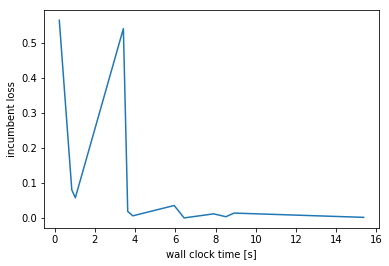

In [11]:
# Step 4 Plotting the results

# The returned result object holds informations about the optimization run
# like the incumbent (=best) configuration.
id2config = res.get_id2config_mapping()
print('A total of %i unique configurations where sampled.' % len(id2config.keys()))
print('A total of %i runs where executed.' % len(res.get_all_runs()))
print('Best configuration found: {}'.format(id2config[res.get_incumbent_id()]['config']))

# The incumbent trajectory is a dictionary with all the configuration IDs, the times the runs
# finished, their respective budgets, and corresponding losses.
# It's used to do meaningful plots of the optimization process.
incumbent_trajectory = res.get_incumbent_trajectory()

import matplotlib.pyplot as plt
plt.plot(incumbent_trajectory['times_finished'], incumbent_trajectory['losses'])
plt.xlabel('wall clock time [s]')
plt.ylabel('incumbent loss')
plt.show()

## Using the results in CAVE

### 2.1) Magic Cavtivity 
 HIER kann man Cave einbinden! :) 